In [1]:
import os
import scipy.io
import numpy as np
from scipy import signal

data_path = "/kaggle/input/control1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')

for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []

for control_data_path in control_data:
    n_epochs = 70 
    start_epoch = 1
    end_epoch = 110

    control_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = os.path.join(control_data_path, f"trial{i}.mat")
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]    
        #print(mat_data1.shape)
        # Downsampling
        num_samples_original = mat_data1.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        #print(downsampled_data.shape)
        
        control_arr.append(downsampled_data)
        Control30.append(downsampled_data)

Control30 = np.array(Control30)

print(Control30.shape)


(3300, 60, 1000)


In [3]:
import os
import scipy.io
import numpy as np
from scipy import signal
data_path = "/kaggle/input/concussed1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)

Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 70
    start_epoch = 1
    end_epoch = 110
    concussed_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        num_samples_original = mat_data1.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
        Concussed52.append(downsampled_data)

Concussed52 = np.array(Concussed52)

print( Concussed52.shape)


(5390, 60, 1000)


In [4]:
from scipy.stats import entropy

alpha_band = (8, 12)
beta_band = (12, 35)
delta_band = (.5, 4)
epsilon = 1e-10

Concussed_feature = np.zeros((Concussed52.shape[0], Concussed52.shape[1], Concussed52.shape[2] + 4))

for i in range(Concussed52.shape[0]):
    for j in range(Concussed52.shape[1]):
        channel_data = Concussed52[i, j, :]
        freq_spectrum = np.fft.fft(channel_data)
        power_spectrum = np.abs(freq_spectrum) ** 2

        alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
        delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

        channel_min_value = np.min(channel_data)
        channel_max_value = np.max(channel_data)

        power_spectrum_adjusted = power_spectrum + epsilon
        entropy_values = entropy(power_spectrum_adjusted)
        values = np.array([alpha_power, beta_power, delta_power, entropy_values])
        rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value
        concatenated_data = np.concatenate((channel_data, rescaled_values))

        Concussed_feature[i, j, :-4] = channel_data
        Concussed_feature[i, j, -4:] = rescaled_values

print(Concussed_feature.shape)


(5390, 60, 1004)


In [5]:
dataset = np.concatenate((Control30, Concussed52), axis=0)
labels = np.concatenate((np.zeros(Control30.shape[0]), np.ones(Concussed52.shape[0])))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(60,1000)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=100, batch_size=32)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/100
218/218 [==============================] - 6s 23ms/step - loss: 0.6398 - accuracy: 0.6528
Epoch 2/100
218/218 [==============================] - 5s 22ms/step - loss: 0.5581 - accuracy: 0.7090
Epoch 3/100
218/218 [==============================] - 5s 22ms/step - loss: 0.4734 - accuracy: 0.7759
Epoch 4/100
218/218 [==============================] - 5s 22ms/step - loss: 0.4281 - accuracy: 0.8039
Epoch 5/100
218/218 [==============================] - 5s 24ms/step - loss: 0.3732 - accuracy: 0.8265
Epoch 6/100
218/218 [==============================] - 5s 22ms/step - loss: 0.3707 - accuracy: 0.8403
Epoch 7/100
218/218 [==============================] - 5s 22ms/step - loss: 0.2776 - accuracy: 0.8815
Epoch 8/100
218/218 [==============================] - 5s 22ms/step - loss: 0.2173 - accuracy: 0.9097
Epoch 9/100
218/218 [==============================] - 5s 22ms/step - loss: 0.2041 - accuracy: 0.9202
Epoch 10/100
218/218 [==============================] - 5s 22ms/step - loss: 0.221

In [8]:
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100))


55/55 [==============================] - 1s 9ms/step - loss: 0.9854 - accuracy: 0.8487
Accuracy: 84.87%


In [15]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


55/55 [==============================] - 1s 10ms/step
Confusion Matrix:
[[537 147]
 [116 938]]


In [16]:
from sklearn.metrics import classification_report
target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Control       0.82      0.79      0.80       684
   Concussed       0.86      0.89      0.88      1054

    accuracy                           0.85      1738
   macro avg       0.84      0.84      0.84      1738
weighted avg       0.85      0.85      0.85      1738



Classification Report:
              precision    recall  f1-score   support

     Control       0.82      0.79      0.80       684
   Concussed       0.86      0.89      0.88      1054

    accuracy                           0.85      1738
   macro avg       0.84      0.84      0.84      1738
weighted avg       0.85      0.85      0.85      1738



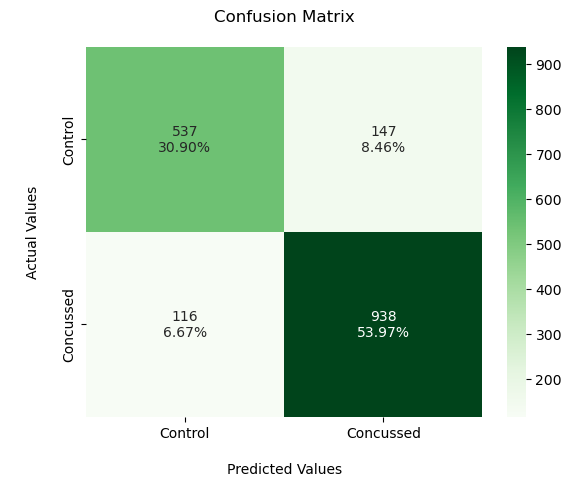

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

ax = sns.heatmap(cm, fmt='', annot=labels, cmap='Greens')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values\n')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

plt.show()


55/55 [==============================] - 0s 8ms/step


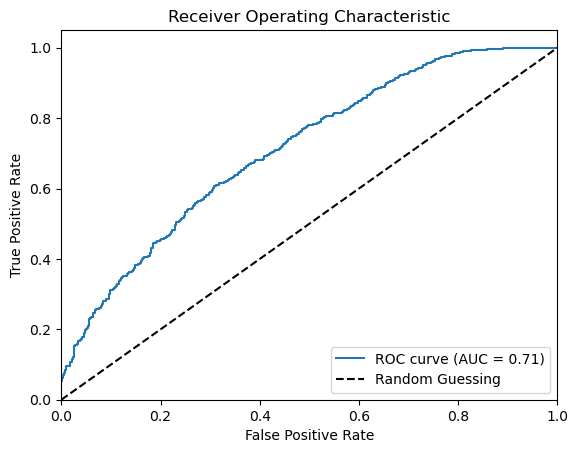

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

X_test_norm = (X_test - mean) / std
y_pred_prob = model.predict(X_test_norm)

y_pred_prob_positive = y_pred_prob[:, 0]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_positive)
roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
